# Gradient Based Estimation

$\hat{\alpha_i}$: the local dictCurve estimate for the $i^{th}$ bag

$\hat{\alpha_{c_i}}$: the $i^{th}$ global distCurve estimate using bootstrapped sample

$w_{ji}$: the contribution of bag j to the $i^{th}$ global estimate

$\tilde{\alpha_i}$: the expected global class prior given the current contribution values and local estimates for each bag

$\tilde{\alpha_i} = \frac{w_{1i} \cdot \hat{\alpha_1} \cdot n_1 \dots w_{Ni} \cdot \hat{\alpha_N} \cdot n_N}{w_{1i} \cdot n_1 \dots w_{Ni} \cdot n_N} $



Loss for cluster $c_i$


$\mathcal{L}_{c_i} = \frac{1}{2}(\tilde{\alpha_i} - \hat{\alpha_{c_i}})^2$

    def gradientMethod(ds):
        alphaHat : init alphaHat for each bag
        alpha_C : get K global alpha estimates
        init W randomly
        for each iteration:
            # calcualte loss given the current values of alphaHat and w
            loss = lossFunction(w[:,1], alpha_C[1]) + ... + lossFunction(w[:,K], alpha_C[K])
            # update alphaHat
            alphaHat = alphaHat - eta * grad(loss)
            # calculate the loss give the current w and new alphaHats
            loss = lossFunction(1) + ... + lossFunction(K)
            w = w - eta * grad(loss)
            getMAE(alphaHat, alpha)

In [1]:
from tqdm.notebook import tqdm

In [2]:
import autograd.numpy as np
from autograd import grad

In [3]:
import matplotlib.pyplot as plt

In [4]:
def getLoss(x,y):
    def loss(w):
        est = np.dot(w,x)
        return .5 * np.square(est - y)
    return loss

In [10]:
def getAlphaLoss(w,n, alphaHats):
    def loss(alpha):
        lossVal = 0
        for wi, aH in zip(w, alphaHats):
            tilde = (1 / np.dot(wi,n)) * np.dot(np.multiply(alpha,wi),n)
            lossVal += .5 * np.square(aH - tilde)
        return lossVal
    return loss
    
def getWLoss(a,n, alphaHat):
    def loss(w):
        lossVal = 0
        for wi,aH in zip(w, alphaHats):
            tilde = (1 / np.dot(wi,n)) * np.dot(np.multiply(a,wi),n)
            lossVal += .5 * np.square(aH - tilde)
        return lossVal
    return loss

In [11]:
from multiinstance.dataset_utils import buildDataset
from multiinstance.utils import *
from multiinstance.distanceApproaches import *
from multiinstance.agglomerative_clustering import AgglomerativeClustering

In [12]:
def getAlphaHat(dsi,reps=10):
    P, U = list(zip(*[dsi.getBag(int(i)) for i in range(dsi.N)]))
    p = np.concatenate(P)
    u = np.concatenate(U)
    alphaHats,_ = getEsts(p,u,reps)
    return alphaHats
    

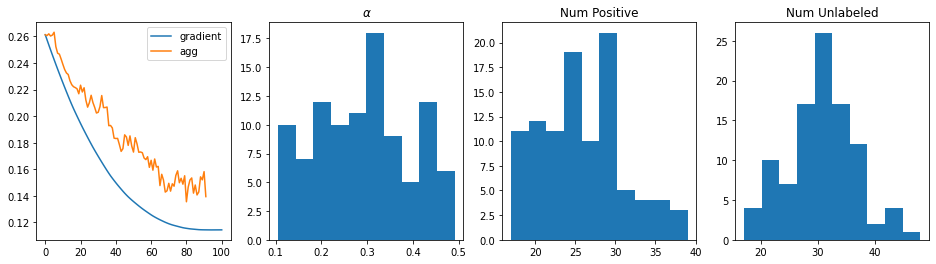

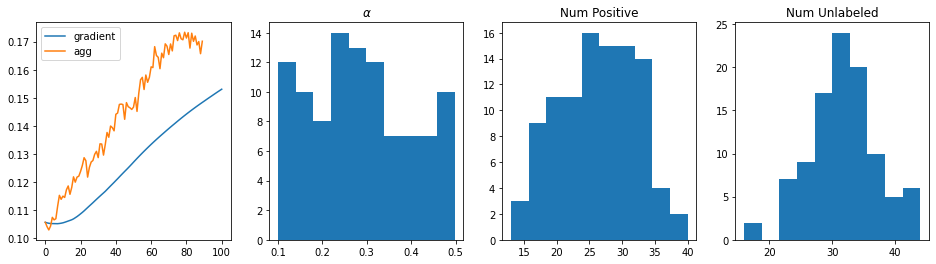

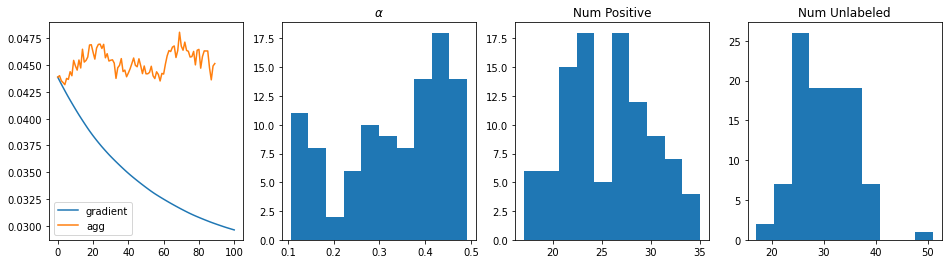

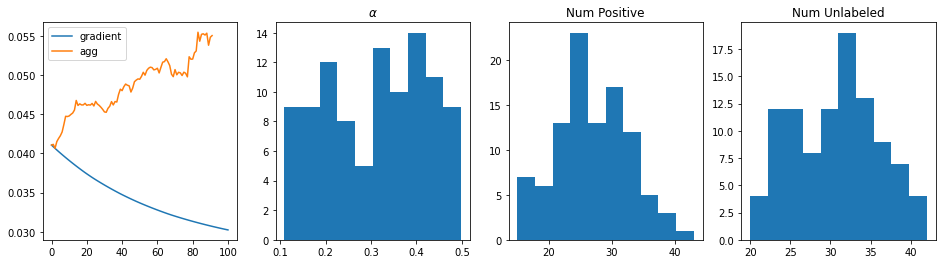

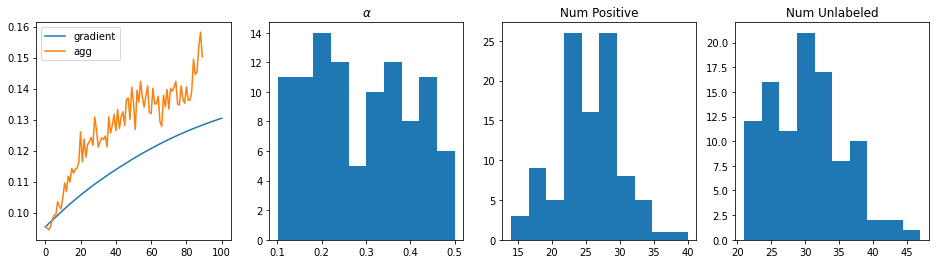

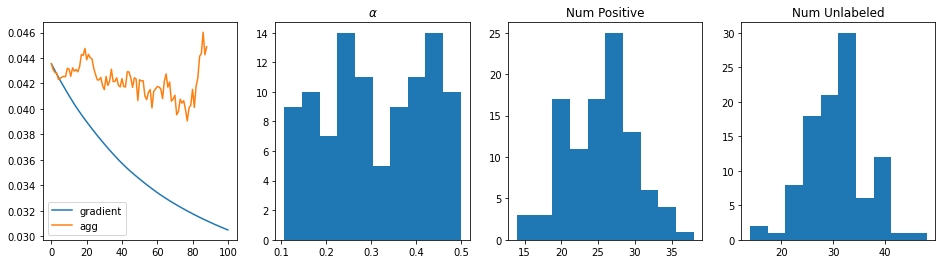

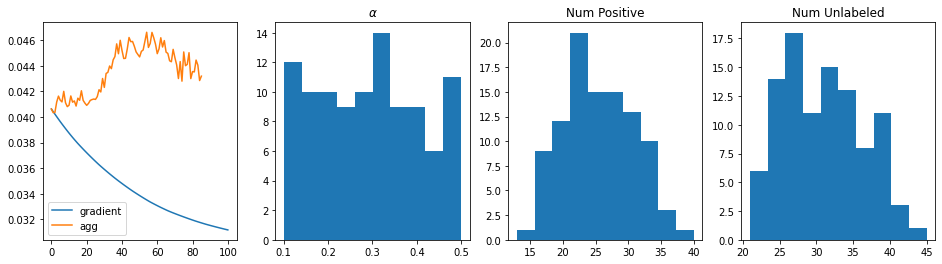

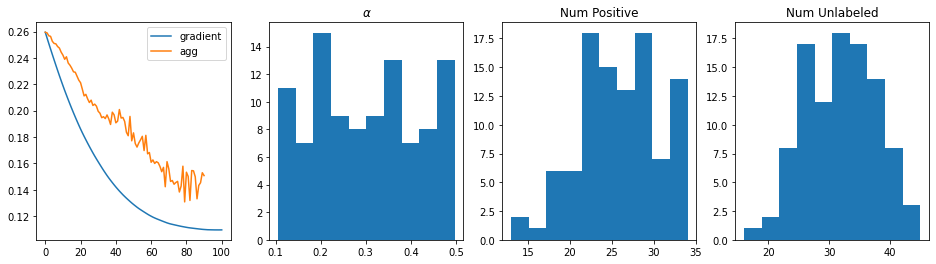

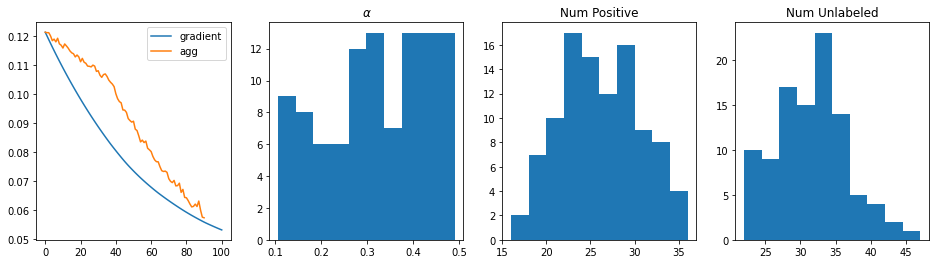

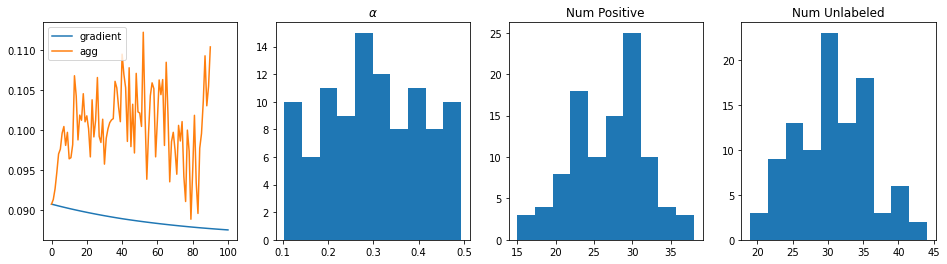

In [24]:
for rep in tqdm(range(10),total=10,desc="reps"):
    # build dataset
    dsi = buildDataset(100,alphaDistr=lambda: np.random.uniform(0.1,.5))

    dsi = addTransformScores(dsi)
    dsi.alphaHats,dsi.curves = getBagAlphaHats(dsi,numbootstraps=10)

    alphaHats = getAlphaHat(dsi,50)
    # initialize values for gradient method
    a = dsi.alphaHats.mean(1)
    n = dsi.numU
    w = np.random.uniform(low=0.01,high=1,size=(len(alphaHats),
                                                n.shape[0]))
    maes = [np.mean(np.abs(a - dsi.trueAlphas.flatten()))]
    epochs = 100
    # Run gradient method
    for i in tqdm(range(epochs),total=epochs):
        alphaLossFn = getAlphaLoss(w,n,alphaHats)
        alphaGrad = grad(alphaLossFn)
        a = a - .025 * alphaGrad(a)
        wLossFn = getWLoss(a,n,alphaHats)
        wGrad = grad(wLossFn)
        w = w - .025 * wGrad(w)
        maes.append(np.mean(np.abs(a - dsi.trueAlphas.flatten())))
    # Run agglomerative clustering
    agg0 = AgglomerativeClustering(dsi, .5,use_alphas_as_scores=False)
    agg0.cluster()
    # plot results
    fig,ax = plt.subplots(1,4,figsize=(16,4))
    ax[0].plot(maes,label="gradient")
    ax[0].plot(agg0.meanAbsErrs,label="agg")
    ax[0].legend()
    ax[1].hist(dsi.trueAlphas)
    ax[1].set_title(r"$\alpha$")
    ax[2].hist(dsi.numP)
    ax[2].set_title("Num Positive")
    ax[3].hist(dsi.numU)
    ax[3].set_title("Num Unlabeled")
    plt.savefig("figs/nb_09/fig_{}.pdf".format(rep),format="pdf")
    plt.show()